- Data can be found at: https://www.kaggle.com/datasets/baronn/lettuce-npk-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import keras
import os
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
DATA_PATH = "../data/LettuceNPKdataset/FNNPK/"

In [3]:
# load data

def load_image(image_id:str):
    image_id = image_id.split('.')[0] if image_id.endswith('.png') else image_id.split('.')[0] if image_id.endswith('.png') else image_id
    file_path = image_id + ".png"
    image = cv.imread(file_path)
    image = cv.resize(image, (300,300))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def load_data() -> dict:
    # load data
    data_dir = '../data/LettuceNPKdataset/FNNPK'
    os.chdir(data_dir)
    dir_list = os.listdir()
    dir_list.sort()
    data = dict()
    for dir_name in tqdm(dir_list, desc='Loading data'):
        os.chdir(dir_name)
        image_list = [load_image(x) for x in os.listdir() if x.lower().endswith('.png')]
        # print(dir_name, len(image_list))
        data[dir_name] = image_list
        os.chdir('..')
    os.chdir('../../../main')
    return data

In [4]:
#plot image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

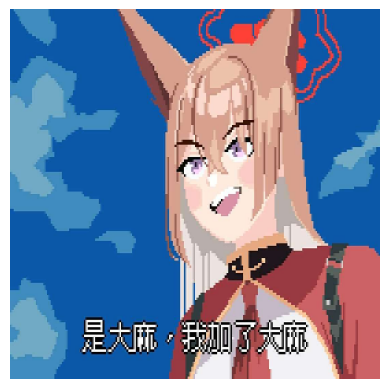

In [5]:
# TEST CODE
test_jpg = load_image('test.png')
plot_image(test_jpg)

In [6]:
# load all data
data = load_data()

Loading data: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


In [7]:
NUM_CLASSES = len(data.keys())
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


In [8]:
# normalize data
def normalize_data(data: dict) -> dict:
    return {k: [x/255.0 for x in v] for k, v in data.items()}

nor_data = normalize_data(data)
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


In [9]:
# plot pie chart of data(labels)
def plot_pie_chart(data: dict):
    plt.figure(figsize=(5, 5))
    plt.pie([len(x) for x in data.values()], labels=[x for x in data.keys()], autopct='%1.1f%%')
    plt.show()

def plot_bar_chart_df(data: pd.DataFrame):
    data.plot(kind='pie', subplots=True, figsize=(5, 5))
    plt.show()

plot_pie_chart(nor_data)

In [10]:
df = pd.DataFrame({'image': [x for x in nor_data.values() for x in x], 'label': [x for x in nor_data.keys() for _ in range(len(nor_data[x]))]})
df.head()

image label
0  [[[0.5725490196078431, 0.5254901960784314, 0.4...    -K
1  [[[0.9176470588235294, 0.9098039215686274, 0.9...    -K
2  [[[0.9882352941176471, 1.0, 1.0], [0.996078431...    -K
3  [[[0.8549019607843137, 0.8470588235294118, 0.8...    -K
4  [[[0.9725490196078431, 0.9725490196078431, 0.9...    -K

In [11]:
# # Data Augmentation for label "FN"
def data_augmentation1(image):
    image = tf.image.flip_left_right(image)
    return image

def data_augmentation2(image):
    image = tf.image.flip_up_down(image)
    return image

def data_augmentation3(image):
    image = tf.image.rot90(image)
    return image

df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation1)
df_aug['label'] = 'FN'
df = pd.concat([df, df_aug], ignore_index=True)
df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation2)
df_aug['label'] = 'FN'
df:pd.DataFrame = pd.concat([df, df_aug], ignore_index=True)
df_aug = df
df_aug['image'] = df_aug['image'].apply(data_augmentation3)
df:pd.DataFrame = pd.concat([df, df_aug], ignore_index=True)

C:\Users\hiban\AppData\Local\Temp\ipykernel_7996\1704196927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['image'] = df_aug['image'].apply(data_augmentation1)
C:\Users\hiban\AppData\Local\Temp\ipykernel_7996\1704196927.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['label'] = 'FN'
C:\Users\hiban\AppData\Local\Temp\ipykernel_7996\1704196927.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [12]:
print(f"Number of classes: {len(df['label'].unique())}, Number of images: {len(df)}")

Number of classes: 4, Number of images: 488


In [13]:
df.value_counts('label', normalize=True).plot(kind='pie', subplots=True, figsize=(5, 5))

array([<Axes: >], dtype=object)

In [14]:
# Label Encoding
def label_encoding(label):
    encoder = LabelEncoder()
    label = encoder.fit_transform(label)
    return label, encoder

df['label'], encoder = label_encoding(df['label'])
df.head()

image  label
0  (((tf.Tensor(0.5803921568627451, shape=(), dty...      0
1  (((tf.Tensor(0.9686274509803922, shape=(), dty...      0
2  (((tf.Tensor(0.8588235294117647, shape=(), dty...      0
3  (((tf.Tensor(0.9450980392156862, shape=(), dty...      0
4  (((tf.Tensor(0.9725490196078431, shape=(), dty...      0

In [15]:
for i, x in enumerate(encoder.classes_):
    print(f"Class {i}: {x}")

Class 0: -K
Class 1: -N
Class 2: -P
Class 3: FN


In [16]:
# Turn data into tensor and split data
def split_data(data: dict, test_size: float=0.2) -> tuple:
    X = np.array([x for x in data['image']])
    y = np.array([x for x in data['label']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df.to_dict('list'))
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (390, 300, 300, 3), y_train: (390,), X_test: (98, 300, 300, 3), y_test: (98,)


In [17]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (390, 300, 300, 3), y_train shape: (390,)
X_test shape: (98, 300, 300, 3), y_test shape: (98,)


In [18]:
INPUT_SHAPE = X_train[0].shape

In [19]:
# Create model
model = keras.Sequential([
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
opt = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()
acc = keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=opt, loss=loss, metrics=[acc])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 128)     0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2841728)           0         
                                                                 
 dense (Dense)               (None, 128)               363741312 
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 363745412 (1.36 GB)
Trainable params: 363745412 (1.36 GB)
Non-trainable params: 0 (0.00 Byte)
____________

In [20]:
# Train model
EPOCHS = 25
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/25

13/13 [==============================] - 27s 2s/step - loss: 52.2962 - sparse_categorical_accuracy: 0.3872 - val_loss: 3.1508 - val_sparse_categorical_accuracy: 0.5408
Epoch 2/25
13/13 [==============================] - 26s 2s/step - loss: 0.7646 - sparse_categorical_accuracy: 0.8282 - val_loss: 0.8240 - val_sparse_categorical_accuracy: 0.7653
Epoch 3/25
13/13 [==============================] - 26s 2s/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.4012 - val_sparse_categorical_accuracy: 0.8776
Epoch 4/25
13/13 [==============================] - 26s 2s/step - loss: 0.0159 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2358 - val_sparse_categorical_accuracy: 0.9388
Epoch 5/25
13/13 [==============================] - 26s 2s/step - loss: 0.0042 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2630 - val_sparse_categorical_accuracy: 0.8776
Epoch 6/25
13/13 [==============================] - 26s 2s/step - loss: 0.0018 - sparse_categorical_accuracy

In [21]:
# Plot loss and accuracy

def plot_loss_and_accuracy(history: keras.callbacks.History):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

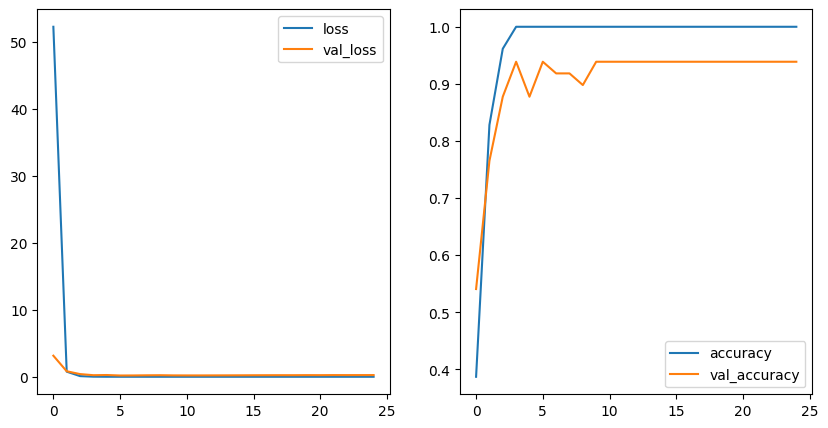

4/4 [==============================] - 1s 238ms/step


In [23]:
plot_loss_and_accuracy(history)
plot_confusion_matrix(model, X_test, y_test)

In [24]:
# save model
model.save('../models/lettuce_npk_model.keras')

In [25]:
# save encoder
import pickle
with open('../models/lettuce_npk_encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)